# Predicting Heart Disease 

## Introduction

Heart disease is currently the leading cause of death from a non-transmissible source with 8.9 million people dying from it annually (Filate et al. 2003; Health Agency of Canada 2018). This is mainly due to a growing aging population making it so a larger portion of people are more prone to cardiovascular diseases (Health Agency of Canada 2018; Statista 2021). However, the disease takes years to develop and is very easily preventable by monitoring or reducing risk factors through various lifestyle changes such as eating a healthy diet, increasing physical activity, and limiting smoking and alcohol consumption (Statista 2021; Government of Canada, 2017). Therefore, early detection of risk factors can help prevent heart disease from developing, or can help prevent the progression of the disease. 

Hence, our research question is:
How can age, blood pressure, cholesterol, heart rate, and number of major blood vessels predict heart disease?

For this analysis we will be using the modified Cleveland dataset from the Heart Disease Data Set from the UCI Machine Learning Repository. The dataset consists of 15 different attributes as follows:

1) age: Age of person in years

2) sex: (1 = male, 0 = female)

3) cp_type: The types of chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)

4) rest_bp: Resting blood pressure (mm Hg on admission to the hospital)

5) chol: serum cholesterol in mg/dl

6) fbs: Fasting blood sugar (if > 120 mg/dl, 1 = true; 0 = false)

7) restecg: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes’ criteria)

8) max_hr: Maximum heart rate achieved

9) eia: Exercise induced angina (1 = yes; 0 = no)

10) op: ST depression induced by exercise relative to rest (‘ST’ relates to positions on the ECG plot)

11) slope: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)

12) num_bv: The number of major vessels (0–3)

13) thal: A blood disorder called thalassemia (1 = normal; 2 = fixed defect; 3 = reversible defect)

14) class: With or without heart disease (buff = healthy, sick = heart disease)

15) health: Heart disease (0 = no, 1, 2, 3, 4 = yes)

To create our model we will be selecting age, resting blood pressure, max heart rate, cholesterol, and the number of major vessels for our predictors. Then we will be using the class as our predicted attribute. 


## Exploratory Analysis

In [1]:
#Downloading the necessary packages.
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
library(digest)
library(infer)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#Setting the seed.
set.seed(1234)

#Dowloading the data from the web and reading it in R.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/cleve.mod"
download.file (url,"cleve.mod" )
colnames <-c("age","sex","cp_type","rest_bp", "chol", 
             "fbs","restecg","max_hr","eia", 
             "op","slope","num_bv","thal","class","health") #Adding column names
clev_data <-read_delim("cleve.mod", skip=20, delim="   ", col_names = colnames) %>%
    mutate(class = as_factor(class)) %>% #Wrangling data and selecting columns to be used in prediction
    mutate(max_hr = as.numeric(max_hr))%>%
    mutate(num_bv = as.numeric(num_bv))%>%
    mutate(rest_bp = as.numeric(rest_bp)) %>%
    select(age, rest_bp, chol, max_hr, num_bv, class) %>%
    filter(class == "buff" | class == "sick")

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_character(),
  cp_type = col_character(),
  rest_bp = col_character(),
  chol = col_double(),
  fbs = col_character(),
  restecg = col_character(),
  max_hr = col_character(),
  eia = col_character(),
  op = col_character(),
  slope = col_character(),
  num_bv = col_character(),
  thal = col_character(),
  class = col_character(),
  health = col_character()
)

Warning message:
“Problem with `mutate()` input `num_bv`.
ℹ NAs introduced by coercion
ℹ Input `num_bv` is `as.numeric(num_bv)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [3]:
#Splitting the data into a training and a testing set.
#75% of the data will be randomly taken as training data.
clev_split <- initial_split(clev_data, prop = 0.75, strata = class)  
clev_train <- training(clev_split)   
clev_test <- testing(clev_split)
head(clev_train)

age,rest_bp,chol,max_hr,num_bv,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,0,buff
67,160,286,108,3,sick
67,120,229,129,2,sick
41,130,204,172,0,buff
57,120,354,163,0,buff
63,130,254,147,1,sick


In [4]:
#Visualizing the summary of the predictor variables.
summary(clev_train)
nrow(clev_train)

      age           rest_bp           chol           max_hr     
 Min.   :29.00   Min.   : 94.0   Min.   :131.0   Min.   : 71.0  
 1st Qu.:48.00   1st Qu.:120.0   1st Qu.:211.0   1st Qu.:136.0  
 Median :56.00   Median :130.0   Median :240.5   Median :154.0  
 Mean   :54.63   Mean   :132.2   Mean   :245.9   Mean   :150.0  
 3rd Qu.:61.00   3rd Qu.:140.0   3rd Qu.:273.0   3rd Qu.:165.8  
 Max.   :77.00   Max.   :192.0   Max.   :417.0   Max.   :202.0  
                                                                
     num_bv         class    
 Min.   :0.0000   buff :123  
 1st Qu.:0.0000   sick :103  
 Median :0.0000    buff:  0  
 Mean   :0.6471    sick:  0  
 3rd Qu.:1.0000              
 Max.   :3.0000              
 NA's   :5                   

[1] 226

In [5]:
#Cleaining the data by removing the missing values in num_bv.
clev_train_clean <- clev_train %>%
    filter(num_bv != "NA")
clev_test_clean <- clev_test %>%
    filter(num_bv != "NA")

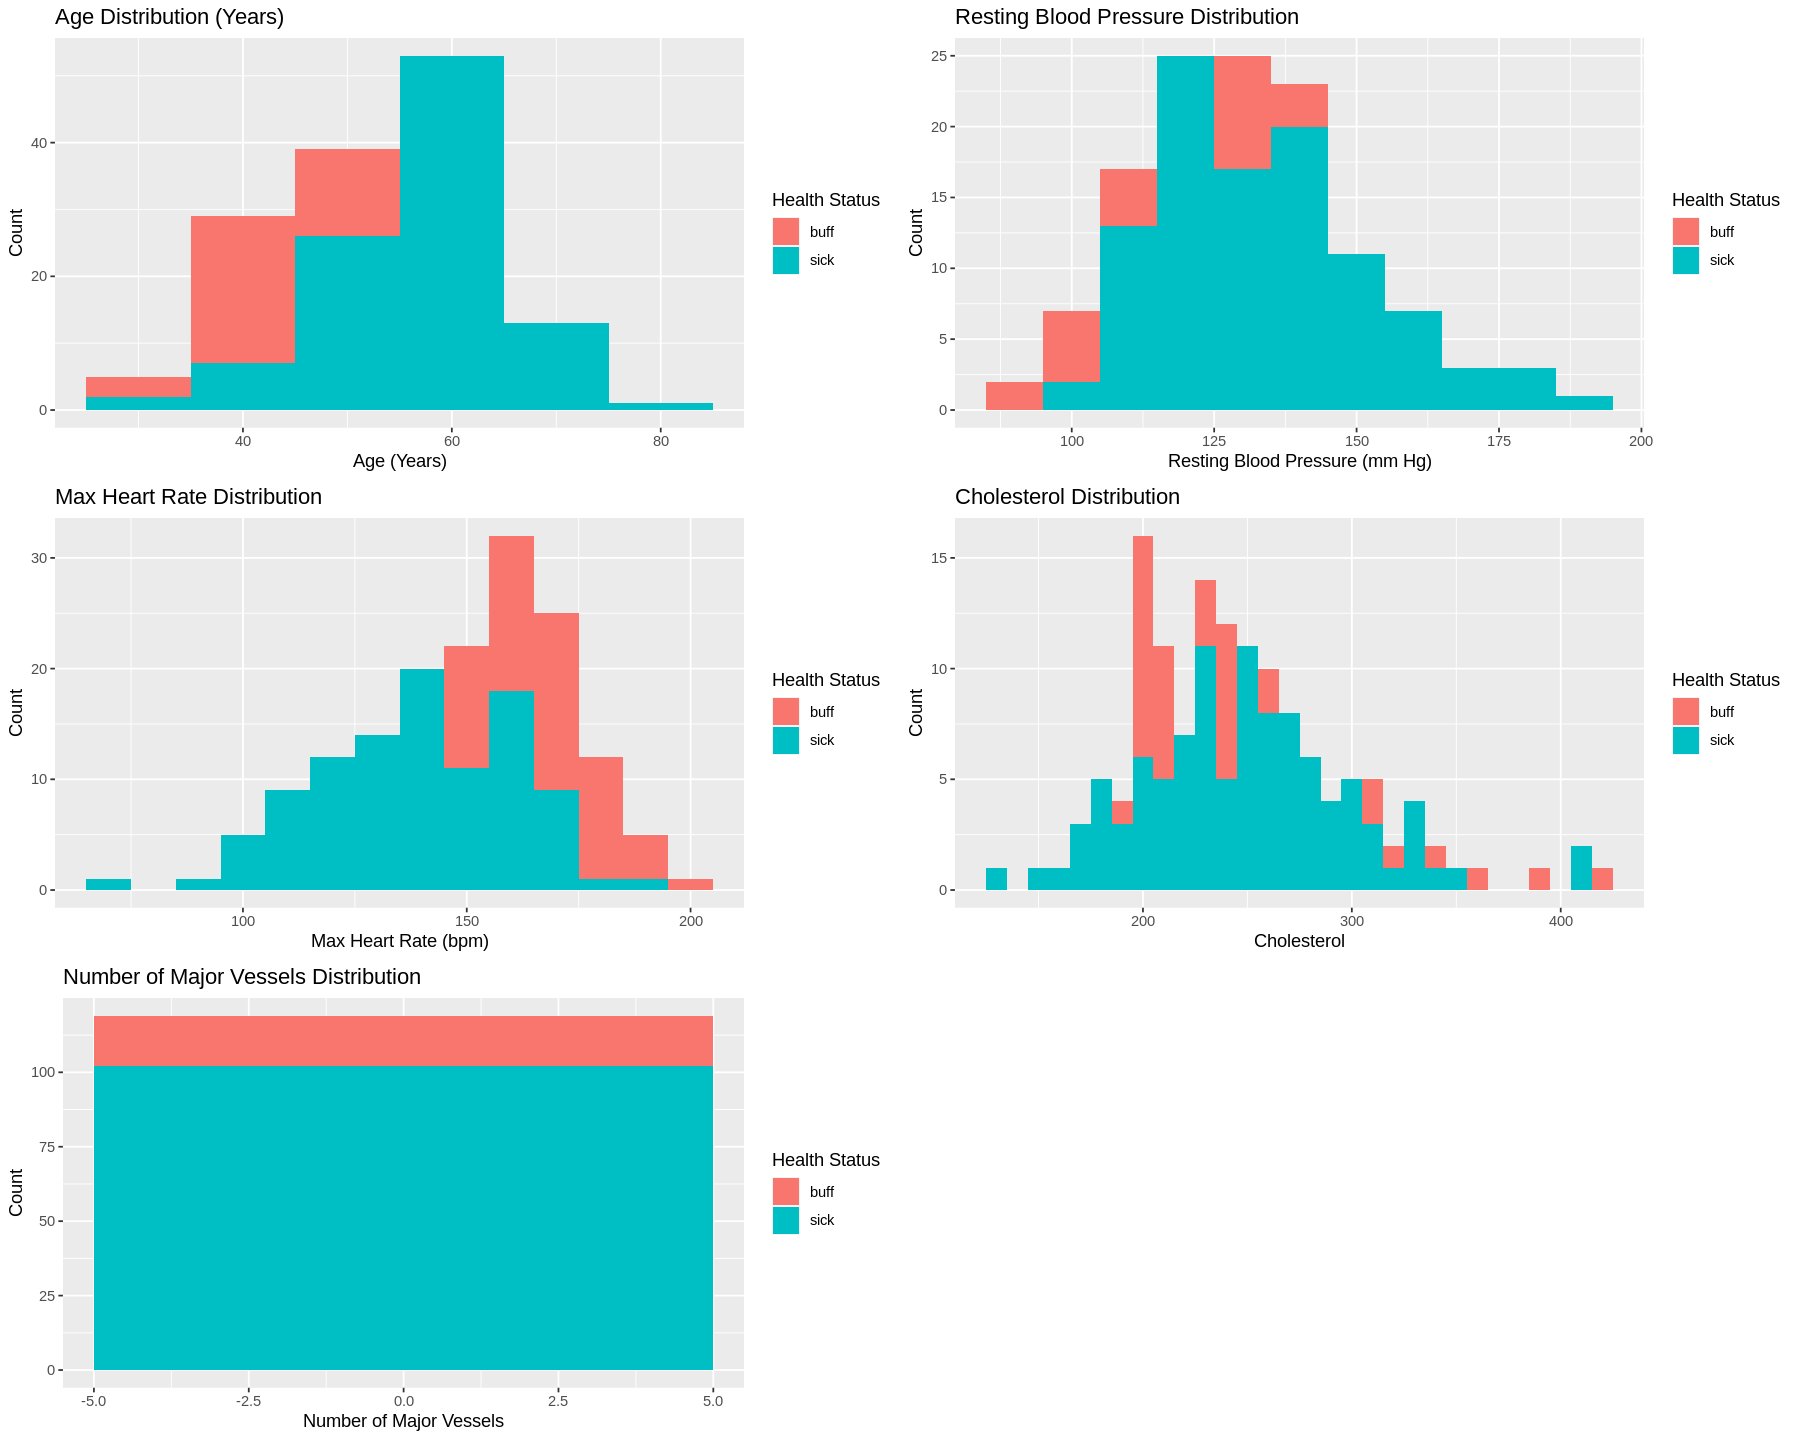

In [6]:
options(repr.plot.width = 15, repr.plot.height = 12)

#Visualizing the relationships between two predictor variables with training data.
plot_0 <- clev_train_clean %>%  
    ggplot(aes(x=chol, y=max_hr, color=class))+
    geom_point()+
    labs(x="Cholesterol", y="Max Heart Rate", color="Health Status")+
    ggtitle("Cholesterol vs Max Heart Rate")
  #to see the correlation between cholesterol levels and maximum heart rate and if they together are strong predictors of heart disease

plot_1 <- clev_train_clean %>%
    ggplot(aes(x=age, y=chol, color=class))+
    geom_point()+
    labs(x="Age", y="Cholesterol", color="Health Status")+
    ggtitle("Age vs Cholesterol")
 #to see the correlation between cholesterol levels and age and if they together are strong predictors of heart disease 

#Visualizing the distribution of each predictor variable
plot_2 <- clev_train_clean %>%
    ggplot(aes(x=age, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Age (Years)", y="Count", fill="Health Status")+
    ggtitle("Age Distribution (Years)")
  #to see the correlation between age and heart disease to see if age alone can be a strong predictor 

plot_3 <- clev_train_clean %>%
    ggplot(aes(x=rest_bp, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Resting Blood Pressure (mm Hg)", y="Count", fill="Health Status")+
    ggtitle("Resting Blood Pressure Distribution")
 #to see the correlation between resting blood pressure and heart disease to see if resting blood pressure alone can be a strong predictor

plot_4 <- clev_train_clean %>%
    ggplot(aes(x=max_hr, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Max Heart Rate (bpm)", y="Count", fill="Health Status")+
    ggtitle("Max Heart Rate Distribution")
 #to see the correlation between maximum heart rate and heart disease to see if maximum heart rate alone can be a strong predictor  

plot_5 <- clev_train_clean %>%
    ggplot(aes(x=chol, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Cholesterol", y="Count", fill="Health Status")+
    ggtitle("Cholesterol Distribution")
  #to see the correlation between cholesterol levels and heart disease to see if cholesterol levels alone can be a strong predictor 

plot_6 <- clev_train_clean %>%
    ggplot(aes(x=num_bv, fill=class))+
    geom_histogram(position="identity", binwidth = 10)+
    labs(x="Number of Major Vessels", y="Count", fill="Health Status")+
    ggtitle("Number of Major Vessels Distribution")
 #to see the correlation between number of major blood vessels and heart disease to see if having a certain number of healthy blood

#Showing the distribution graphs side by side
    plot_grid(plot_2, plot_3, plot_4, plot_5, plot_6, ncol = 2)


#Explain what each graph means

Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message in (function (data, mapping, alignPercent = 0.6, method = "pearson", :
“Removed 5 rows containing missing values”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing non-finite values (stat_density).”


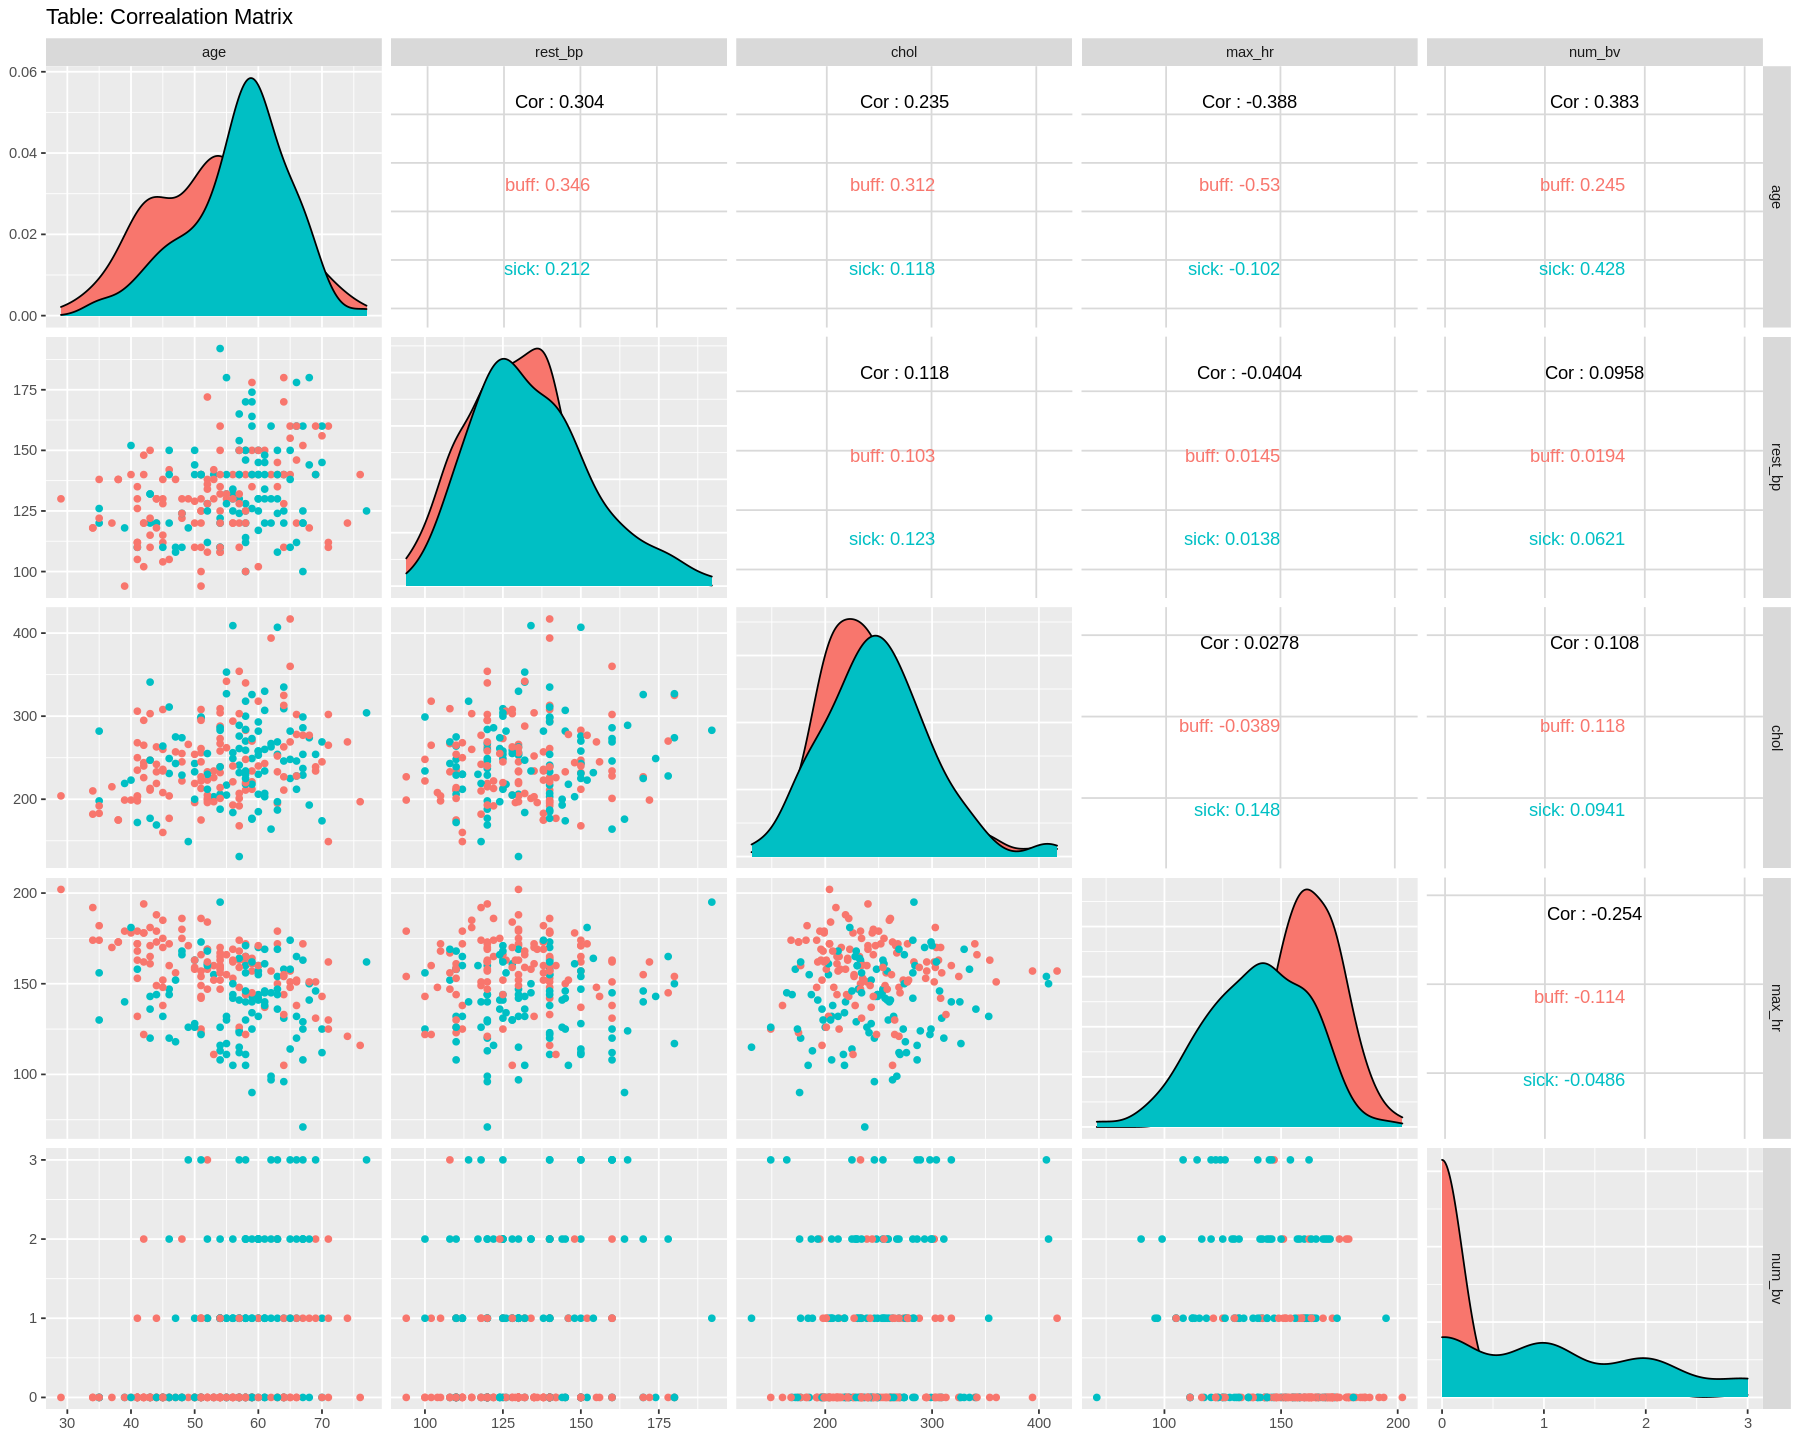

In [7]:
#Visualizing the correalation between each variable
heart_pairs <- clev_train %>%
ggpairs(columns = 1:5, ggplot2::aes(colour = class), title = "Table: Correalation Matrix")
heart_pairs

#explain why we choose each predictor based on correalation 

In [9]:
names <- colnames(clev_train_clean %>% select(-class))
names

[1] "age"     "rest_bp" "chol"    "max_hr"  "num_bv"

In [13]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(clev_train_clean, v = 5, strata = class)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = clev_train_clean) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(heart_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = heart_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold3: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold4: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold5: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold3: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold4: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold5: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,class ~ num_bv,0.7239840
2,class ~ num_bv+max_hr,0.7415457
3,class ~ num_bv+max_hr+age,0.7689382
4,class ~ num_bv+max_hr+age+rest_bp,0.7593235
5,class ~ num_bv+max_hr+age+rest_bp+chol,0.7231525


## Methods:
We will do a classification to predict if the individual has heart disease or not. The predictors we will be using are cholesterol, number of major blood vessels, maximum heart rate, age, and blood presssure. We are using k-nearest neighbours to do our classification because since there are many predictors, finding the nearest points to the point we are predicting will make the prediction the most accurate. One way we will visualize our results is with a scatterplot that shows the likelihood of heart disease based on certain predictors like maximum heart rate and cholesterol. We hope to find certain predictors that better show the likelihood of heart disease which can help to make it easier to predict it in patients. Futher questions that could come from this are what combinations of two or three predictors show the highest likelihood of heart disease or what combinations are the least accurate. 

## Data Analysis:

In [8]:
# Doing preprocessing and standardizing the predictors by passing the vector and the predictor variables to the recipe function.
clev_recipe <- recipe(class ~  age + rest_bp + chol + max_hr + num_bv, data = clev_train_clean )%>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())
clev_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [9]:
#Doing a 5-fold cross-validation. First step of finding the optimal K value that will be used.
clev_vfold <- vfold_cv(clev_train_clean, v = 5, strata = class)

In [10]:
#Creating a model specification with tuning on the number of neighbours.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [12]:
#Creating a data frame with neighbors variable containing values from 1 to 50.
k_range <- tibble(neighbors = seq(from = 1, to = 10))

#Creating a workflow analysis that combines the recipe and the model specification and that tunes 10 values for K.
vfold_metrics <- workflow() %>%
       add_recipe(clev_recipe) %>%
       add_model(knn_tune) %>%
       tune_grid(resamples =clev_vfold, grid = k_range) %>%
       collect_metrics()
#Filtering for accuracy to find the best value of the number of neighbors. 
accuracy <- filter(vfold_metrics, .metric=="accuracy")
accuracy

! Fold1: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold2: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold3: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold4: internal: No observations were detected in `truth` for level(s): ' buff'...

! Fold5: internal: No observations were detected in `truth` for level(s): ' buff'...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6428588,5,0.028493235,Model01
2,accuracy,multiclass,0.6428588,5,0.028493235,Model02
3,accuracy,multiclass,0.7511651,5,0.020076964,Model03
4,accuracy,multiclass,0.7511651,5,0.020076964,Model04
5,accuracy,multiclass,0.7192272,5,0.012814757,Model05
6,accuracy,multiclass,0.7192272,5,0.012814757,Model06
7,accuracy,multiclass,0.6963895,5,0.017526553,Model07
8,accuracy,multiclass,0.6963895,5,0.017526553,Model08
9,accuracy,multiclass,0.7058985,5,0.006491618,Model09


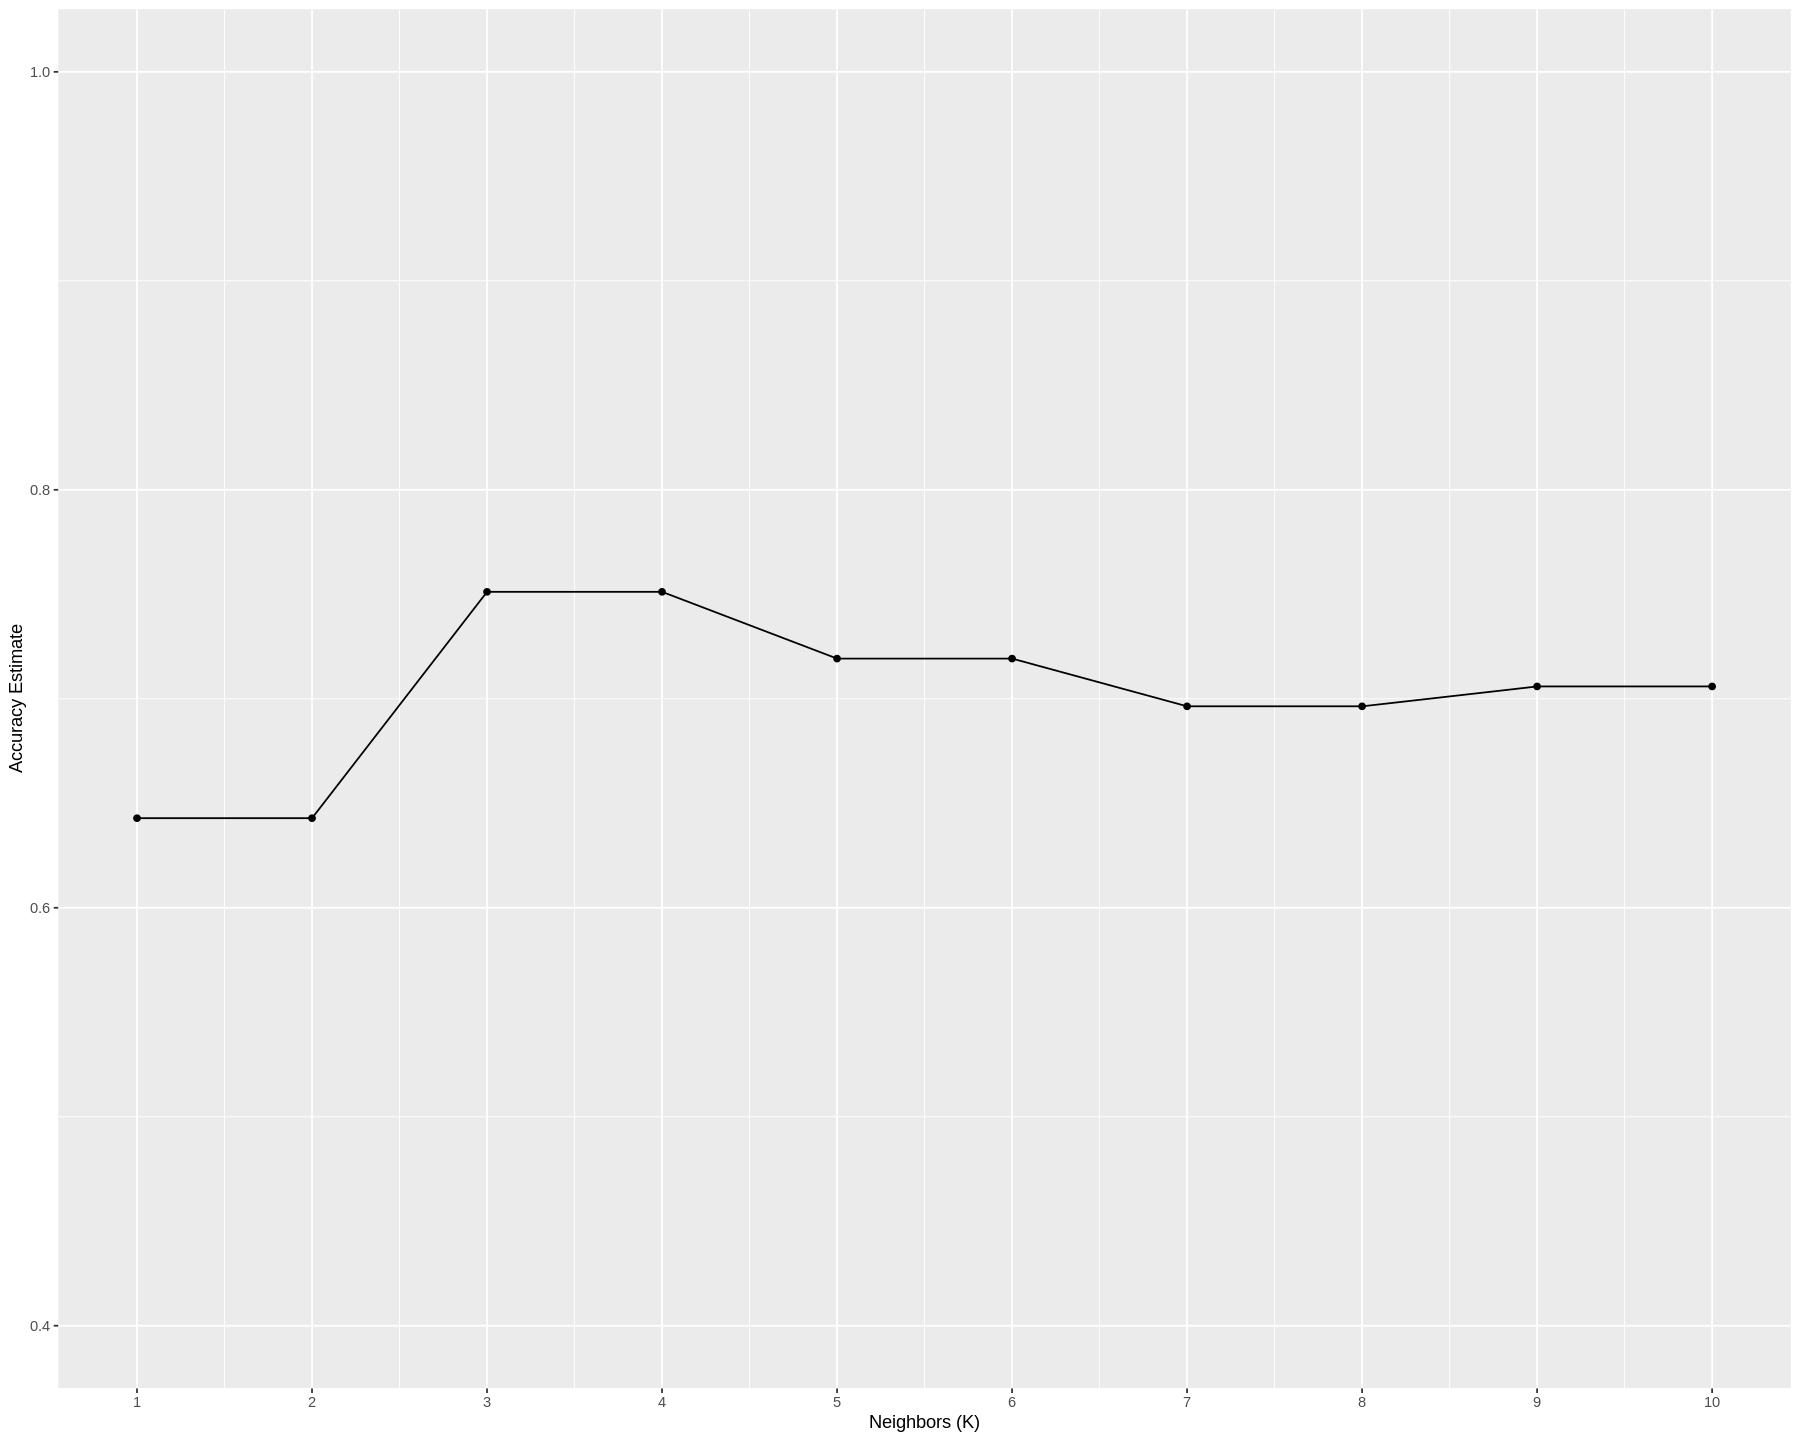

In [13]:
#Creating a K vs accuracy plot to find the best value of the number of neighbors.
cross_val_plot <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
        geom_line()+
       labs(x = "Neighbors (K)", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(0, 24, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
cross_val_plot

In [20]:
#Pulling the K value that creates the highest accuracy.
k_val <- accuracy %>%
    arrange(mean)%>%
    slice(10)%>%
    pull(neighbors)
#Building the model, workflow analysis and fitting the model to trainin data with the best K value found above.
final_spec <- nearest_neighbor(weight_func= "rectangular", neighbors = k_val)%>%
    set_engine("kknn")%>%
    set_mode("classification")

final_workflow <-workflow()%>%
    add_recipe(clev_recipe)%>%
    add_model(final_spec)

final_fit <- final_workflow %>%
    fit(data=clev_train_clean)
final_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_val,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2760181
Best kernel: rectangular
Best k: 4

In [21]:
#Using the final model to predict on the test dataset and finding the accuracy of the model.
predictions <-predict(final_fit, clev_test_clean)%>%
bind_cols(clev_test_clean)

final_metrics <-predictions %>%
    metrics(truth=class, estimate=.pred_class)
final_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8000000
kap,multiclass,0.5913549


In [22]:
#Reporting the confusion matrix.
clev_conf_mat <-predictions %>%
    conf_mat(truth=class, estimate=.pred_class)
clev_conf_mat

          Truth
Prediction buff sick  buff  sick
     buff    36   10     0     0
     sick     5   24     0     0
      buff    0    0     0     0
      sick    0    0     0     0

## Sources

Filate, Woganee A., Helen L. Johansen, Courtney C. Kennedy, and Jack V. Tu. 2003. “Regional Variations in Cardiovascualr Mortality in Canada.” Canadian Journal of Cardiology 11 (19): 1241.

Government of Canada. 2017. “Heart Disease in Canada.” Canada.ca. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html.

Health Agency of Canada. 2018. “Report from the Canadian Chronic Disease Surveillance System: Heart Disease in Canada.” Canadian Electronic Library/desLibris. https://go.exlibris.link/CPyKsFFV.

Statista. 2021. “Death rate for major cardiovascular diseases in Canada from 2000 to 2019.” https://www.statista.com/statistics/434439/death-rate-for-major-cardiovascular-diseases-in-canada/.
